## Tweet Sentiment Analysis
#### Daniel Vance
Resources:
- http://marcobonzanini.com/2015/05/17/mining-twitter-data-with-python-part-6-sentiment-analysis-basics/

- http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

- http://www.laurentluce.com/posts/twitter-sentiment-analysis-using-python-and-nltk/

In [1]:
# Import Statements
%matplotlib inline
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes  import BernoulliNB
from sklearn import datasets, linear_model
from matplotlib import pyplot as plt
from matplotlib import dates as md
from unicodedata import category
from random import shuffle
import pandas as pd
import numpy  as np
import nltk
import json
import time
import csv

input_file: I've been having to clean my tweet files. The have these lines that are like {limit: some timestamp} they aren't very long but because they don't have the keys: "id", "entities", etc. The code to clean the file is:
```python
input_file  = "E:\\root\\input4.txt"
output_file = "E:\\root\\input_clean.txt"
with open(input_file, 'r') as in_file, open(output_file, 'w') as out_file:
    for line in in_file:
        if len(line) < 100:
            continue
        else:
            out_file.write(line)
```
I haven't included it in a runnable cell because I already did it. If you need to just create a cell and run the code.

In [2]:
# Change the input file to the location of your file of tweets in the JSON format.
input_file = "E:\\root\\input_clean_tight.txt"
# Declare the dictionaries for the data that we want to capture from the tweets
text = {}
hashtags = {}
locations = {}
timestamps = {}

with open(input_file, 'r') as file:
    for line in file:
        tweet = json.loads(line.strip())
        # Adjust these as necessary. Twitter has tons of different attributes
        # that can be referenced
        tweet_id = tweet["id"]
        timestamps[tweet_id] = tweet["created_at"]        
        text[tweet_id] = tweet["text"]
        for hashtag in tweet['entities']['hashtags']:
            hashtags[tweet_id] = hashtag["text"]
        value = tweet["user"]["location"]
        if value is not None:
            locations[tweet_id] = value

Create dataframes from the dictionaries that we just created. I did the above step before determining if I was going to put the data into a dataframes. There is probably a way to import the data from the json format into a dataframes. I didn't take the time to find it.

In [3]:
tweet_timestamp_df = pd.DataFrame.from_dict(list(timestamps.items()), orient="columns")
tweet_timestamp_df.columns = ["id", "timestamp"]
tweet_text_df      = pd.DataFrame.from_dict(list(text.items()))
tweet_text_df.columns = ["id", "tweet"]
tweet_hashtags_df  = pd.DataFrame.from_dict(list(hashtags.items()))
tweet_hashtags_df.columns = ["id", "hashtag"]
tweet_locations_df = pd.DataFrame.from_dict(list(locations.items()))
tweet_locations_df.columns = ["id", "location"]

results is a python dataframe where we merge the four dataframes we just created into on large on joining on column "id."

In [4]:
# Since timestamp and tweets should come from every tweet parsed, 
# there should be a 1:1 mapping, thus we use an inner join
results = pd.merge(tweet_timestamp_df, tweet_text_df, how="inner", on="id")

# Not every tweet uses hashtags or location, thus we want to do a left join
# on our key
results = pd.merge(results, tweet_hashtags_df, how="left", on="id")
results = pd.merge(results, tweet_locations_df, how="left", on="id")

In [245]:
# The number of tweets in the experiment
len(results)

561261

Create dataframes for each candidate from the results dataframe where the tweet contains the candidates name. Since the tweet includes the hashtags, it should catch tweets where the only mention of the candidate is in the hashtag as well. Then drop the columns that are NaN from the dataframe. 

In [5]:
trump_tweets_df = results[["id", "timestamp", "tweet", "hashtag", "location"]]\
                            .where(results.tweet.str.contains("[Tt]rump")).dropna()

cruz_tweets_df = results[["id", "timestamp", "tweet", "hashtag", "location"]]\
                            .where(results.tweet.str.contains("[Cc]ruz")).dropna()

clinton_tweets_df = results[["id", "timestamp", "tweet", "hashtag", "location"]]\
                            .where(results.tweet.str.contains("[Cc]linton")).dropna()

sanders_tweets_df = results[["id", "timestamp", "tweet", "hashtag", "location"]]\
                            .where(results.tweet.str.contains("[Ss]anders")).dropna()

In [6]:
candidates = [("Trump", trump_tweets_df), ("Cruz", cruz_tweets_df), ("Clinton", clinton_tweets_df), 
              ("Sanders", sanders_tweets_df)]
for candidate, df in candidates:
    print(candidate, ":", len(df))

Trump : 44341
Cruz : 17311
Clinton : 5951
Sanders : 6043


Ones: create a list of ones [1, 1,... , 1] the length of the candidates dataframe. 
Use pandas DatetimeIndex to create an ndarray of timestamps that we use to index the candidates pandas Series. The Series is then resample, which puts a frequency of one minute for the candidate's time Series of one minute, then it sums up the "ones" for each frequency.
Got the basis of this code from: http://marcobonzanini.com/2015/05/17/mining-twitter-data-with-python-part-6-sentiment-analysis-basics/

In [7]:
def tweets_per_minute(df, freq):
    ones = [1] * len(df)
    time_results = pd.DatetimeIndex(df.timestamp)
    time_series = pd.Series(ones, index=time_results)
    return time_series.resample(freq).sum().dropna()

In [8]:
# We are summing up the number of tweets per minute, thus the 1min frequenncy
freq = "1Min"

trump_per_minute = tweets_per_minute(trump_tweets_df, freq)
cruz_per_minute = tweets_per_minute(cruz_tweets_df, freq)
clinton_per_minute = tweets_per_minute(clinton_tweets_df, freq)
sanders_per_minute = tweets_per_minute(sanders_tweets_df, freq)

Plot the data.

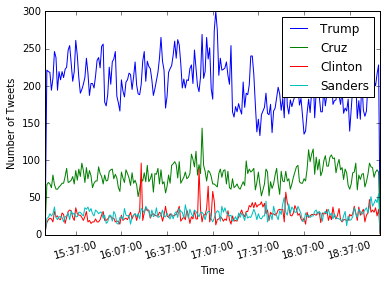

In [9]:
# plot_dict is a dictionary of pandas Series.
plot_dict = dict(trump=trump_per_minute, cruz=cruz_per_minute, clinton=clinton_per_minute, sanders=sanders_per_minute)
# Since Trump is tweeted about the most per minute, use his index as the new dataframes index
plot_data = pd.DataFrame(data=plot_dict, index=trump_per_minute.index)
#Resample the new dataframe
plot_data = plot_data.resample("1Min").sum()


plt.xlabel("Time")
plt.ylabel("Number of Tweets")

plt.plot(plot_data["trump"], label="Trump")
plt.plot(plot_data["cruz"], label="Cruz")
plt.plot(plot_data["clinton"], label="Clinton")
plt.plot(plot_data["sanders"], label="Sanders")


xfmt = md.DateFormatter('%H:%M:%S')
ax=plt.gca()
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()
# Rotate the labels so they don't overlap
plt.xticks(rotation=15)


plt.legend()
plt.show()

Used *Thinknook's* Twitter sentiment data set with 1.5 Million labeled tweets. Labels are 0 for negative and 1 for positive. 
http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

In [11]:
sentiment_csv = 'E:\\root\\Sentiment Analysis Dataset.csv'
positive_tweets = []
negative_tweets = []

with open(sentiment_csv, 'r', newline='', encoding='utf-8') as csv_text:
    reader = csv.reader(csv_text)
    next(reader)            # Skip the header row
    for row in reader:
        sentiment = row[1]
        tweet = row[3]
        if sentiment == "1": # 1 == Positive Tweet
            positive_tweets.append((tweet, "positive"))
        else:
            negative_tweets.append((tweet, "negative"))

In [231]:
print("{0:2.4}%".format(len(positive_tweets) / len(labeled_tweets) * 100))

50.06%


In [12]:
# Filter out words that are less than three characters and lower case
# the words. I also filtered out unicode characters which I believe
# should include emoji, since I do not have a good way of determining
# if those symbols are positive or negative. It is definitely something
# to play with in the future
labeled_tweets = positive_tweets + negative_tweets

filtered_tweets = []
for (words, sentiment) in labeled_tweets:
    # words_cleaned = ''.join(ch for ch in words if category(ch)[0] != 'P') # P for punctuation
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3]    
    filtered_tweets.append((words_filtered, sentiment))

In [13]:
# Shuffle the tweets to randomize them and then break them into training sets. 
shuffle(filtered_tweets)

In [14]:
training_set = filtered_tweets[0:10000]        #5000
test_set_a = filtered_tweets[10000:11000]          #1000
test_set_b = filtered_tweets[12000:13000]          #1000
small_training_set = filtered_tweets[14000:14050]  #0050
small_test_set = filtered_tweets[14050: 14100]     #0050

In [15]:
# Helper functions from 
# http://www.laurentluce.com/posts/twitter-sentiment-analysis-using-python-and-nltk/

def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words

def get_word_features(word_list):
    word_list = nltk.FreqDist(word_list)
    word_features = list(word_list.keys())
    return word_features

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features[word] = (word in document_words)
    return features

# word_features is used in the extract_features function and must be 
# defined before extract_features is used. 
word_features = get_word_features(get_words_in_tweets(filtered_tweets[100000: 110000])) #10000

In [17]:
print("Number of word features:", len(word_features))

Number of word features: 26433


In [18]:
# Apply the extract_features function to the tweets that will be used
# for the training set tweets and the testing set tweets.
training_tweets = nltk.classify.apply_features(extract_features, training_set)
testing_tweets = nltk.classify.apply_features(extract_features, test_set_a)

In [20]:
# The classifier.
classifier = nltk.NaiveBayesClassifier.train(training_tweets)

In [22]:
classifier.show_most_informative_features(100)

Most Informative Features
                     sad = True           negati : positi =     32.6 : 1.0
                   stuck = True           negati : positi =     13.5 : 1.0
                  hungry = True           negati : positi =     13.1 : 1.0
                horrible = True           negati : positi =     11.7 : 1.0
                 welcome = True           positi : negati =     11.7 : 1.0
               goodnight = True           positi : negati =     11.6 : 1.0
                   thank = True           positi : negati =     10.6 : 1.0
                happened = True           negati : positi =     10.4 : 1.0
                    sad. = True           negati : positi =     10.4 : 1.0
                   shame = True           negati : positi =     10.4 : 1.0
                    sick = True           negati : positi =     10.3 : 1.0
                   slept = True           negati : positi =      9.1 : 1.0
                  sucks. = True           negati : positi =      9.1 : 1.0

In [23]:
# Accuracy check. Use the testing set testing_tweets
print(nltk.classify.accuracy(classifier, testing_tweets))

0.717


In [24]:
# Need to take random samples from the candidates tweets in order
# to make classifying them tractable. Weeks would have been required
# to classify all of the tweets on my current setup.
n_samples = 500
trump_sample_df = trump_tweets_df.sample(n=n_samples)
cruz_sample_df = cruz_tweets_df.sample(n=n_samples)
clinton_sample_df = clinton_tweets_df.sample(n=n_samples)
sanders_sample_df = sanders_tweets_df.sample(n=n_samples)

In [27]:
def classify_tweets(df, verbose=False):
    count = 0
    dictionary = {}
    for index, id, timestamp, tweet, hashtag, location in df.itertuples():
        time_start = time.time()
        sentiment = classifier.classify(extract_features(tweet.split()))
        if sentiment == "positive":
            dictionary[id] = sentiment
        else:
            dictionary[id] = sentiment
        count += 1
        time_remaining = (time.time() - time_start) * (len(df) - count) / 60
        if verbose:
            print(count, '/', len(df), "::: Time Remaining for this candidate: {0:0.2f} minutes".\
                                                 format(time_remaining))
    return dictionary

In [28]:
# Classify the candidates' tweets into dictionaries for the
# positive ones. Use print statement for feedback that the 
# script hasn't frozen. 
trump_sentiment   = classify_tweets(trump_sample_df, verbose=True)
cruz_sentiment    = classify_tweets(cruz_sample_df)
clinton_sentiment = classify_tweets(clinton_sample_df)
sanders_sentiment = classify_tweets(sanders_sample_df)

1 / 500 ::: Time Remaining for this candidate: 3.13 minutes
2 / 500 ::: Time Remaining for this candidate: 3.03 minutes
3 / 500 ::: Time Remaining for this candidate: 2.95 minutes
4 / 500 ::: Time Remaining for this candidate: 2.87 minutes
5 / 500 ::: Time Remaining for this candidate: 2.85 minutes
6 / 500 ::: Time Remaining for this candidate: 2.77 minutes
7 / 500 ::: Time Remaining for this candidate: 3.02 minutes
8 / 500 ::: Time Remaining for this candidate: 2.99 minutes
9 / 500 ::: Time Remaining for this candidate: 2.85 minutes
10 / 500 ::: Time Remaining for this candidate: 2.90 minutes
11 / 500 ::: Time Remaining for this candidate: 2.85 minutes
12 / 500 ::: Time Remaining for this candidate: 2.90 minutes
13 / 500 ::: Time Remaining for this candidate: 2.89 minutes
14 / 500 ::: Time Remaining for this candidate: 2.76 minutes
15 / 500 ::: Time Remaining for this candidate: 2.83 minutes
16 / 500 ::: Time Remaining for this candidate: 2.83 minutes
17 / 500 ::: Time Remaining for t

In [29]:
# Create Pandas dataframes from the dictionaries that we just classified
trump_tweet_sentiment_df = pd.DataFrame.from_dict(list(trump_sentiment.items()))
trump_tweet_sentiment_df.columns = ["id", "sentiment"]

cruz_tweet_sentiment_df = pd.DataFrame.from_dict(list(cruz_sentiment.items()))
cruz_tweet_sentiment_df.columns = ["id", "sentiment"]

clinton_tweet_sentiment_df = pd.DataFrame.from_dict(list(clinton_sentiment.items()))
clinton_tweet_sentiment_df.columns = ["id", "sentiment"]

sanders_tweet_sentiment_df = pd.DataFrame.from_dict(list(sanders_sentiment.items()))
sanders_tweet_sentiment_df.columns = ["id", "sentiment"]

In [37]:
def merge_sentiment_tweets(left_df, right_df, columns_list, join="left", s="positive"):
    # s can be positive or negative; it is the sentiment you want to merge on
    df = pd.merge(left_df, right_df, how=join, on=columns_list[0])
    return df[columns_list].where(df.sentiment == s).dropna()

In [32]:
# Merge the pandas DataFrame with the existing DataFrame collection 
# for the purpose of getting the timestamp for the tweets. There is 
# probably a way to create the DataFrame when we classified the tweet
# but I haven't had time to research it yet.
columns = ["id", "timestamp", "tweet", "hashtag", "location", "sentiment"]

trump_tweets_positive_df = merge_sentiment_tweets(trump_tweets_df, trump_tweet_positive_df, columns)
cruz_tweets_positive_df  = merge_sentiment_tweets(cruz_tweets_df, cruz_tweet_positive_df, columns)
clinton_tweets_positive_df = merge_sentiment_tweets(clinton_tweets_df, clinton_tweet_positive_df, columns)
sanders_tweets_positive_df = merge_sentiment_tweets(sanders_tweets_df, sanders_tweet_positive_df, columns)

In [39]:
trump_tweets_negative_df = merge_sentiment_tweets(trump_tweets_df, trump_tweet_positive_df, columns, s="negative")
cruz_tweets_negative_df  = merge_sentiment_tweets(cruz_tweets_df, cruz_tweet_positive_df, columns, s="negative")
clinton_tweets_negative_df = merge_sentiment_tweets(clinton_tweets_df, clinton_tweet_positive_df, columns, s="negative")
sanders_tweets_negative_df = merge_sentiment_tweets(sanders_tweets_df, sanders_tweet_positive_df, columns, s="negative")

In [40]:
def df_length(desc, df): print("{0}: {1}".format(desc, len(df)))

In [41]:
candidates = [("Trump", trump_tweets_positive_df), ("Cruz", cruz_tweets_positive_df),
              ("Clinton", clinton_tweets_positive_df), ("Sanders", sanders_tweets_positive_df)]

for candidate, df in candidates:
    df_length(candidate, df)    

Trump: 365
Cruz: 341
Clinton: 365
Sanders: 418


In [42]:
candidates = [("Trump", trump_tweets_negative_df), ("Cruz", cruz_tweets_negative_df),
              ("Clinton", clinton_tweets_negative_df), ("Sanders", sanders_tweets_negative_df)]

for candidate, df in candidates:
    df_length(candidate, df)    

Trump: 135
Cruz: 159
Clinton: 135
Sanders: 82


In [48]:
data_frames = [trump_tweets_positive_df, trump_tweets_negative_df, cruz_tweets_positive_df,
               cruz_tweets_negative_df, clinton_tweets_positive_df, clinton_tweets_negative_df,
               sanders_tweets_positive_df, sanders_tweets_negative_df]
csv = "E:\\root\\candidate_sentiment_tweets.csv"
for df in data_frames:
    if df is data_frames[0]:
        df.to_csv(csv, quoting=1)
    else:
        df.to_csv(csv, mode='a', header=False, quoting=1)

In [49]:
# We are summing up the number of tweets per minute, thus the 1min frequenncy
freq = "1Min"

trump_per_minute = tweets_per_minute(trump_tweets_positive_df, freq)
cruz_per_minute = tweets_per_minute(cruz_tweets_positive_df, freq)
clinton_per_minute = tweets_per_minute(clinton_tweets_positive_df, freq)
sanders_per_minute = tweets_per_minute(sanders_tweets_positive_df, freq)

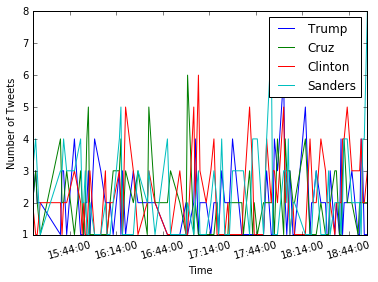

In [50]:
# plot_dict is a dictionary of pandas Series.
plot_dict = dict(trump=trump_per_minute, cruz=cruz_per_minute, clinton=clinton_per_minute, sanders=sanders_per_minute)

plot_data = pd.DataFrame(data=plot_dict, index=trump_per_minute.index)
#Resample the new dataframe
plot_data = plot_data.resample("1Min").sum().dropna()


plt.xlabel("Time")
plt.ylabel("Number of Tweets")
xfmt = md.DateFormatter('%H:%M:%S')
ax=plt.gca()
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

plt.plot(plot_data["trump"], label="Trump")
plt.plot(plot_data["cruz"], label="Cruz")
plt.plot(plot_data["clinton"], label="Clinton")
plt.plot(plot_data["sanders"], label="Sanders")

# Rotate the labels so they don't overlap
plt.xticks(rotation=15)

plt.legend()
plt.show()

To see if time had any linear effect on the data, we ran a linear regression on the tweets, but it did not come up with anything ground shaking. 

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

r^2 = 0.00326935829778
Coefficient = [-1.49801178]
Intercept = 1102607.22011


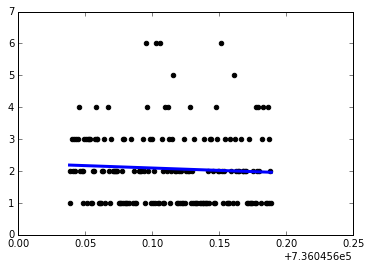

In [51]:
date_nums = md.date2num([index for index, key in trump_per_minute.iteritems()])
x = date_nums.reshape(len(trump_per_minute),1)

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(x, trump_per_minute)
print("r^2 =", regr.score(x, trump_per_minute))
print("Coefficient =", regr.coef_)
print("Intercept =", regr.intercept_)

plt.scatter(x, trump_per_minute, color="black")
plt.plot(x, regr.predict(x), color="blue", linewidth=3)
plt.show()

r^2 = 0.00262424663791
Coefficient = [-1.22161099]


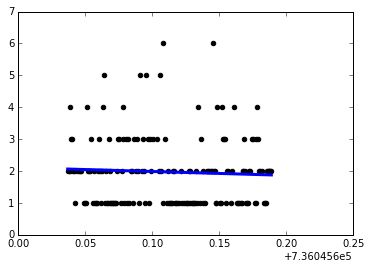

In [52]:
date_nums = md.date2num([index for index, key in cruz_per_minute.iteritems()])
x = date_nums.reshape(len(cruz_per_minute),1)

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(x, cruz_per_minute)
print("r^2 =", regr.score(x, cruz_per_minute))
print("Coefficient =", regr.coef_)

plt.scatter(x, cruz_per_minute, color="black")
plt.plot(x, regr.predict(x), color="blue", linewidth=3)
plt.show()

r^2 = 0.0665101551957
Coefficient = [ 6.67214771]


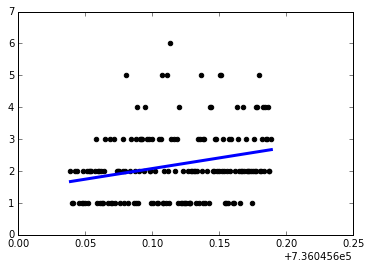

In [53]:
date_nums = md.date2num([index for index, key in clinton_per_minute.iteritems()])
x = date_nums.reshape(len(clinton_per_minute),1)

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(x, clinton_per_minute)
print("r^2 =", regr.score(x, clinton_per_minute))
print("Coefficient =", regr.coef_)

plt.scatter(x, clinton_per_minute, color="black")
plt.plot(x, regr.predict(x), color="blue", linewidth=3)
plt.show()

r^2 = 0.00720455485427
Coefficient = [ 2.30889069]


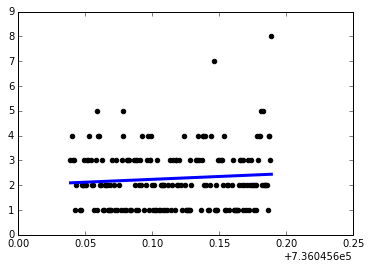

In [54]:
date_nums = md.date2num([index for index, key in sanders_per_minute.iteritems()])
x = date_nums.reshape(len(sanders_per_minute),1)

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(x, sanders_per_minute)
print("r^2 =", regr.score(x, sanders_per_minute))
print("Coefficient =", regr.coef_)

plt.scatter(x, sanders_per_minute, color="black")
plt.plot(x, regr.predict(x), color="blue", linewidth=3)
plt.show()

Need to get the total tweets for each candidate for the states that were having primaries that day

In [55]:
def tweets_from_state(df):
    return df.loc[df["location"].str.contains("/ AZ|Arizona| ID|Idaho| UT|Utah/i")]

In [56]:
# Need to get the total tweets for each candidate for the states that were having primaries that day
trump_states_df = tweets_from_state(trump_tweets_df)
cruz_states_df = tweets_from_state(cruz_tweets_df)
clinton_states_df = tweets_from_state(clinton_tweets_df)
sanders_states_df = tweets_from_state(sanders_tweets_df)

In [152]:
# Classify the candidates' tweets into dictionaries for the
# positive ones. Use print statement for feedback that the 
# script hasn't frozen. 
trump_positive_states   = {}
cruz_positive_states    = {}
clinton_positive_states = {}
sanders_positive_states = {}

# Use a tuple of the candidate's random sample of tweets and the dictionary for the positive
# ones from that sample. Used a list of tuples so that I could iterate through it in a for loop 
candidates_tuples = [(trump_states_df, trump_positive_states), (cruz_states_df, cruz_positive_states),
                     (clinton_states_df, clinton_positive_states), (sanders_states_df, sanders_positive_states)]

for candidate_df, candidate_dict in candidates_tuples:
    classify_tweets(candidate_df, candidate_dict)

1 / 563 ::: Time Remaining for this candidate: 466.94 minutes
2 / 563 ::: Time Remaining for this candidate: 1.34 minutes
3 / 563 ::: Time Remaining for this candidate: 1.36 minutes
4 / 563 ::: Time Remaining for this candidate: 1.28 minutes
5 / 563 ::: Time Remaining for this candidate: 1.35 minutes
6 / 563 ::: Time Remaining for this candidate: 1.26 minutes
7 / 563 ::: Time Remaining for this candidate: 1.35 minutes
8 / 563 ::: Time Remaining for this candidate: 1.31 minutes
9 / 563 ::: Time Remaining for this candidate: 1.36 minutes
10 / 563 ::: Time Remaining for this candidate: 1.27 minutes
11 / 563 ::: Time Remaining for this candidate: 1.35 minutes
12 / 563 ::: Time Remaining for this candidate: 1.27 minutes
13 / 563 ::: Time Remaining for this candidate: 1.33 minutes
14 / 563 ::: Time Remaining for this candidate: 1.26 minutes
15 / 563 ::: Time Remaining for this candidate: 1.30 minutes
16 / 563 ::: Time Remaining for this candidate: 1.30 minutes
17 / 563 ::: Time Remaining for

In [153]:
# Create Pandas dataframes from the dictionaries that we just classified
trump_positive_states_df = pd.DataFrame.from_dict(list(trump_positive_states.items()))
trump_positive_states_df.columns = ["id", "sentiment"]

cruz_positive_states_df = pd.DataFrame.from_dict(list(cruz_positive_states.items()))
cruz_positive_states_df.columns = ["id", "sentiment"]

clinton_positive_states_df = pd.DataFrame.from_dict(list(clinton_positive_states.items()))
clinton_positive_states_df.columns = ["id", "sentiment"]

sanders_positive_states_df = pd.DataFrame.from_dict(list(sanders_positive_states.items()))
sanders_positive_states_df.columns = ["id", "sentiment"]

In [154]:
# Merge the pandas DataFrame with the existing DataFrame collection 
# for the purpose of getting the sentiment for the tweets.
columns = ["id", "timestamp", "tweet", "hashtag", "location", "sentiment"]

trump_tweets_state_df = merge_positive_tweets(trump_states_df, trump_positive_states_df, columns)
cruz_tweets_state_df = merge_positive_tweets(cruz_states_df, cruz_positive_states_df, columns)
clinton_tweets_state_df = merge_positive_tweets(clinton_states_df, clinton_positive_states_df, columns)
sanders_tweets_state_df = merge_positive_tweets(sanders_states_df, sanders_positive_states_df, columns)

In [266]:
def tweet_by_state(p, df, states_list):
    print("Counts for {0}:".format(p))
    for state in states_list:
        print(state[0], len(df.loc[df["location"].isin(state)]))
    print("-" * 20)

In [267]:
states = [["Arizona", "AZ"]
         ,["Idaho", "ID"]
         ,["Utah", "UT"]]

tweet_by_state("Trump", trump_tweets_state_df, states)
tweet_by_state("Cruz", cruz_tweets_state_df, states)
tweet_by_state("Clinton", clinton_tweets_state_df, states)
tweet_by_state("Sanders", sanders_tweets_state_df, states)

print("Tweets with locations vs total tweets:\n{0}/{1} = {2:0.2f}".\
      format(results.location.count(), len(results),
             results.location.count() / len(results)))

Counts for Trump:
Arizona 84
Idaho 30
Utah 0
--------------------
Counts for Cruz:
Arizona 39
Idaho 10
Utah 0
--------------------
Counts for Clinton:
Arizona 6
Idaho 6
Utah 0
--------------------
Counts for Sanders:
Arizona 9
Idaho 3
Utah 0
--------------------
Tweets with locations vs total tweets:
302866/561261 = 0.54


In [269]:
random_sample_tweets   = {}
random_sample_df = results.sample(2000)
classify_tweets(random_sample_df, random_sample_tweets, output=True)

1 / 75 ::: Time Remaining for this candidate: 8.57 minutes
2 / 75 ::: Time Remaining for this candidate: 0.08 minutes
3 / 75 ::: Time Remaining for this candidate: 0.08 minutes
4 / 75 ::: Time Remaining for this candidate: 0.10 minutes
5 / 75 ::: Time Remaining for this candidate: 0.09 minutes
6 / 75 ::: Time Remaining for this candidate: 0.07 minutes
7 / 75 ::: Time Remaining for this candidate: 0.08 minutes
8 / 75 ::: Time Remaining for this candidate: 0.08 minutes
9 / 75 ::: Time Remaining for this candidate: 0.09 minutes
10 / 75 ::: Time Remaining for this candidate: 0.07 minutes
11 / 75 ::: Time Remaining for this candidate: 0.07 minutes
12 / 75 ::: Time Remaining for this candidate: 0.08 minutes
13 / 75 ::: Time Remaining for this candidate: 0.07 minutes
14 / 75 ::: Time Remaining for this candidate: 0.07 minutes
15 / 75 ::: Time Remaining for this candidate: 0.07 minutes
16 / 75 ::: Time Remaining for this candidate: 0.08 minutes
17 / 75 ::: Time Remaining for this candidate: 0.

In [271]:
trump_random_tweets_df = random_sample_df[["id", "timestamp", "tweet", "hashtag", "location"]]\
                            .where(results.tweet.str.contains("[Tt]rump")).dropna()

cruz_random_tweets_df = random_sample_df[["id", "timestamp", "tweet", "hashtag", "location"]]\
                            .where(results.tweet.str.contains("[Cc]ruz")).dropna()

clinton_random_tweets_df = random_sample_df[["id", "timestamp", "tweet", "hashtag", "location"]]\
                            .where(results.tweet.str.contains("[Cc]linton")).dropna()

sanders_random_tweets_df = random_sample_df[["id", "timestamp", "tweet", "hashtag", "location"]]\
                            .where(results.tweet.str.contains("[Ss]anders")).dropna()
    
print("""Trump: {0}
Cruz: {1}
Clinton: {2}
Sanders: {3}
""".format(len(trump_random_tweets_df), len(cruz_random_tweets_df),
           len(clinton_random_tweets_df), len(sanders_random_tweets_df)))

Trump: 162
Cruz: 50
Clinton: 19
Sanders: 26



In [273]:
# We are summing up the number of tweets per minute, thus the 1min frequenncy
freq = "1Min"

trump_per_minute = tweets_per_minute(trump_random_tweets_df, freq)
cruz_per_minute = tweets_per_minute(cruz_random_tweets_df, freq)
clinton_per_minute = tweets_per_minute(clinton_random_tweets_df, freq)
sanders_per_minute = tweets_per_minute(sanders_random_tweets_df, freq)

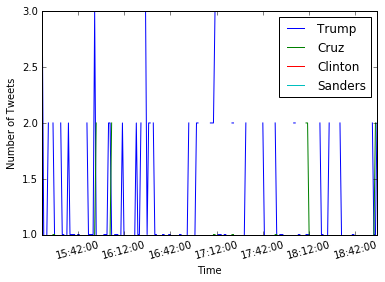

In [276]:
# plot_dict is a dictionary of pandas Series.
plot_dict = dict(trump=trump_per_minute, cruz=cruz_per_minute, clinton=clinton_per_minute, sanders=sanders_per_minute)
# Since Trump is tweeted about the most per minute, use his index as the new dataframes index
plot_data = pd.DataFrame(data=plot_dict, index=trump_per_minute.index)
#Resample the new dataframe
plot_data = plot_data.resample("1Min").sum()


plt.xlabel("Time")
plt.ylabel("Number of Tweets")

plt.plot(plot_data["trump"], label="Trump")
plt.plot(plot_data["cruz"], label="Cruz")
plt.plot(plot_data["clinton"], label="Clinton")
plt.plot(plot_data["sanders"], label="Sanders")


xfmt = md.DateFormatter('%H:%M:%S')
ax=plt.gca()
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()
# Rotate the labels so they don't overlap
plt.xticks(rotation=15)


plt.legend()
plt.show()

Tried to Use Scikit-Learn's BernoulliNB module... It seems to be more efficient and more accurate than NLTK's. It can be used exactly like NLTK's naive Bayesian classifier.
https://pythonprogramming.net/sklearn-scikit-learn-nltk-tutorial/

The problem is that it would eat all my RAM and cause my computer to thrash on larger word features. Thus I went back to the NLTK's Naive Bayes algorithm

In [ ]:
BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_tweets)

MemoryError: 

In [24]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_tweets)

<SklearnClassifier(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))>

In [31]:
print(nltk.classify.accuracy(MNB_classifier, testing_tweets))
print(nltk.classify.accuracy(BNB_classifier, testing_tweets))

0.42
0.44
